 # Astro Trading Pipeline - Modular Research Notebook



 This is the **central orchestrating notebook** that imports and runs all modules.



 ## Pipeline Steps:

 1. Setup & Config

 2. Load Market Data (from PostgreSQL)

 3. Visualize Price

 4. Create Labels (balanced UP/DOWN)

 5. Compute Astro Data

 6. Build Features

 7. Train Model

 8. Evaluate & Visualize

 9. (Optional) Grid Search

 10. Save Model

 ## 0. Environment Check

In [1]:
# Check dependencies
import importlib.util as iu

required = ["xgboost", "sklearn", "matplotlib", "seaborn", "tqdm", "pyarrow", "psycopg2", "swisseph"]
missing = [pkg for pkg in required if iu.find_spec(pkg) is None]

if missing:
    print("Missing packages:", ", ".join(missing))
    print("Install with: conda install -c conda-forge " + " ".join(missing))
else:
    print("✓ All dependencies found")


✓ All dependencies found


 ## 1. Setup & Configuration

In [2]:
# Import RESEARCH modules
import sys
from pathlib import Path

# Find project root and add to path
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "RESEARCH").exists():
    for parent in PROJECT_ROOT.parents:
        if (parent / "RESEARCH").exists():
            PROJECT_ROOT = parent
            break

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"PROJECT_ROOT: {PROJECT_ROOT}")


PROJECT_ROOT: /home/rut/ostrofun


In [3]:
# Import all modules
from RESEARCH.config import cfg, PROJECT_ROOT
from RESEARCH.data_loader import load_market_data, get_latest_date, get_data_paths
from RESEARCH.labeling import create_balanced_labels, gaussian_smooth_centered
from RESEARCH.astro_engine import (
    init_ephemeris,
    calculate_bodies_for_dates,
    calculate_aspects_for_dates,
    calculate_transits_for_dates,
    get_natal_bodies,
)
from RESEARCH.features import (
    build_full_features,
    merge_features_with_labels,
    get_feature_columns,
    get_feature_inventory,
)
from RESEARCH.model_training import (
    split_dataset,
    prepare_xy,
    train_xgb_model,
    tune_threshold,
    predict_with_threshold,
    evaluate_model,
    get_feature_importance,
    check_cuda_available,
)
from RESEARCH.visualization import (
    plot_price_distribution,
    plot_class_distribution,
    plot_price_with_labels,
    plot_last_n_days,
    plot_confusion_matrix,
    plot_feature_importance,
    plot_predictions,
)

print("✓ All RESEARCH modules imported")


✓ All RESEARCH modules imported


In [4]:
# Show configuration
print(f"Active subject: {cfg.active_subject_id}")
print(f"Data root: {cfg.data_root}")
print(f"DB URL configured: {bool(cfg.db_url)}")
print(f"Label config: {cfg.get_label_config()}")


Active subject: btc
Data root: /home/rut/ostrofun/data/market
DB URL configured: True
Label config: {'horizon': 1, 'target_move_share': 0.5, 'gauss_window': 201, 'gauss_std': 50.0, 'price_mode': 'raw'}


 ## 2. Load Market Data

In [5]:
# Load market data from database
df_market = load_market_data()

# Optional: filter by start date
DATA_START = "2017-11-01"
df_market = df_market[df_market["date"] >= DATA_START].reset_index(drop=True)

print(f"\nMarket data: {len(df_market)} rows")
print(f"Date range: {df_market['date'].min().date()} → {df_market['date'].max().date()}")
df_market.head()


Loaded 5677 rows from DB for subject=btc
Date range: 2010-07-18 -> 2026-01-31

Market data: 3014 rows
Date range: 2017-11-01 → 2026-01-31


/home/rut/ostrofun/RESEARCH/data_loader.py:55: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,date,close
0,2017-11-01,6737.8
1,2017-11-02,7024.8
2,2017-11-03,7152.1
3,2017-11-04,7363.8
4,2017-11-05,7389.5


 ## 3. Visualize Price

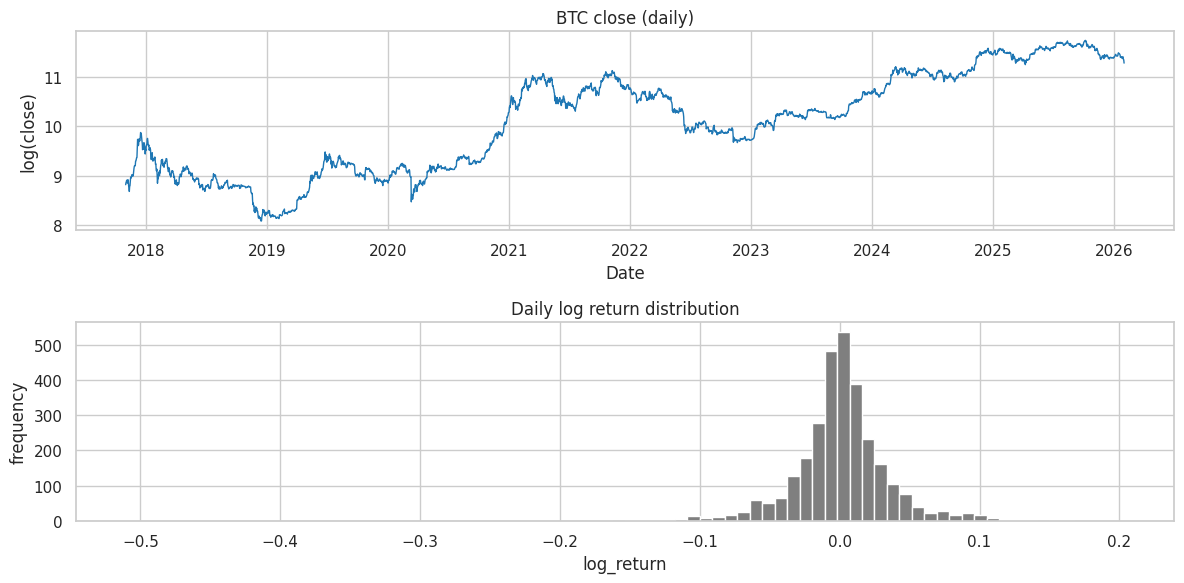

In [6]:
# Price and return distribution
plot_price_distribution(df_market, price_mode="log")


 ## 4. Create Labels

In [7]:
# Configuration for labeling
LABEL_CONFIG = {
    "horizon": 1,           # Prediction horizon (days)
    "move_share": 0.5,      # Total share of samples to keep
    "gauss_window": 201,    # Gaussian window for detrending (odd)
    "gauss_std": 50.0,      # Gaussian std
    "price_mode": "raw",    # 'raw' or 'log'
    "label_mode": "balanced_detrended",
}

# Create balanced labels
df_labels = create_balanced_labels(
    df_market,
    horizon=LABEL_CONFIG["horizon"],
    move_share=LABEL_CONFIG["move_share"],
    gauss_window=LABEL_CONFIG["gauss_window"],
    gauss_std=LABEL_CONFIG["gauss_std"],
    price_mode=LABEL_CONFIG["price_mode"],
    label_mode=LABEL_CONFIG["label_mode"],
)

df_labels.head()


Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30


,date,close,target
0,2017-11-05,7389.5,0
1,2017-11-08,7444.4,0
2,2017-11-09,7129.6,0
3,2017-11-11,6339.9,0
4,2017-11-12,5878.1,1


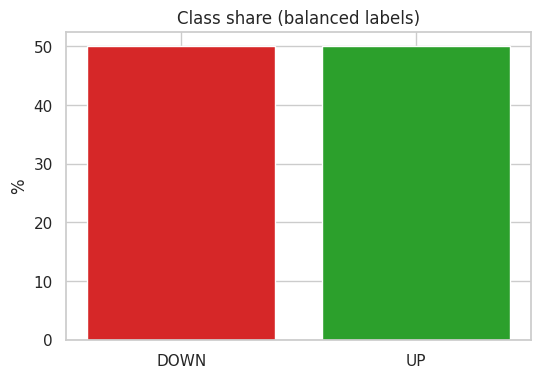

In [8]:
# Class distribution
plot_class_distribution(df_labels)


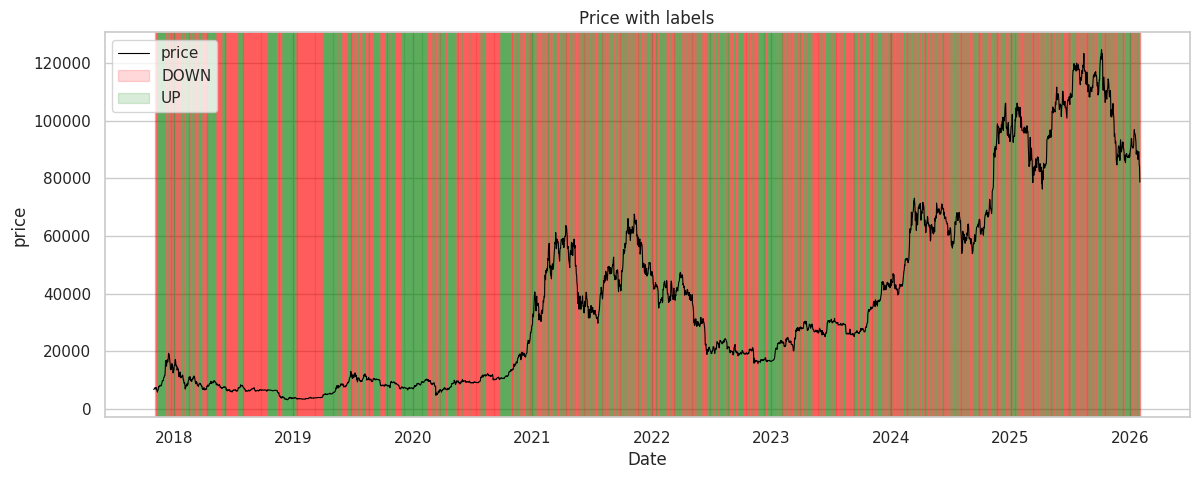

In [9]:
# Price with labels
plot_price_with_labels(df_market, df_labels, price_mode="raw")


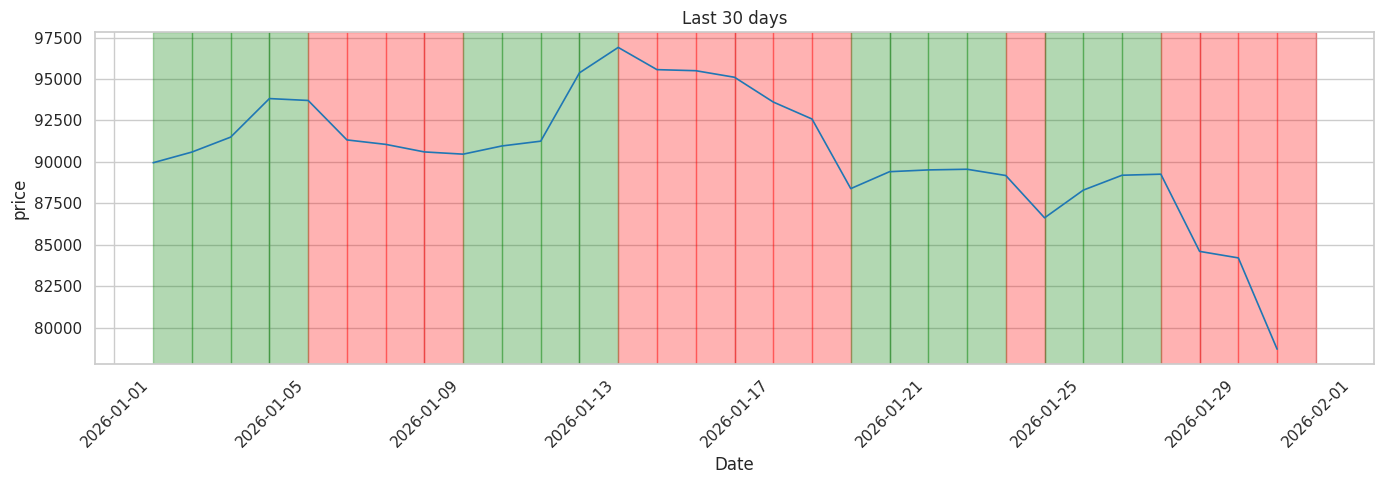

Last 30 days: 30 labeled (forward-filled) out of 30


In [10]:
# Last 30 days
plot_last_n_days(df_market, df_labels, n_days=30)


 ## 5. Compute Astro Data

In [11]:
# Initialize ephemeris
settings = init_ephemeris()
print(f"Bodies: {[b.name for b in settings.bodies]}")
print(f"Aspects: {[a.name for a in settings.aspects]}")


Bodies: ['Sun', 'Moon', 'Mercury', 'Venus', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto', 'TrueNode', 'MeanNode', 'Lilith']
Aspects: ['Conjunction', 'Sextile', 'Square', 'Trine', 'Opposition']


In [12]:
# Calculate body positions for all dates
# (This is fast - no need to cache)
df_bodies, bodies_by_date = calculate_bodies_for_dates(
    df_market["date"],
    settings,
    progress=True,
)

print(f"\nBodies calculated: {len(df_bodies)} rows")
df_bodies.head()


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 21682.31it/s]


Bodies calculated: 39182 rows


,date,body,lon,lat,speed,is_retro,sign,declination
0,2017-11-01,Sun,218.755657,-0.000011,1.000008,False,Scorpio,-0.000011
1,2017-11-01,Moon,356.209228,-2.907350,13.493332,False,Pisces,-2.907350
2,2017-11-01,Mercury,232.905646,-1.409936,1.497015,False,Scorpio,-1.409936
3,2017-11-01,Venus,201.888931,1.488282,1.249436,False,Libra,1.488282
4,2017-11-01,Mars,185.828074,1.137132,0.631064,False,Libra,1.137132


In [13]:
# Calculate aspects
ORB_MULTIPLIER = 1.0  # Adjust orbs (1.0 = default)

df_aspects = calculate_aspects_for_dates(
    bodies_by_date,
    settings,
    orb_mult=ORB_MULTIPLIER,
    progress=True,
)

print(f"\nAspects: {len(df_aspects)} rows")
df_aspects.head()


Calculating aspects (orb=1.0): 100%|██████████| 3014/3014 [00:00<00:00, 35714.56it/s]


Aspects: 48953 rows


,date,p1,p2,aspect,orb,is_exact,is_applying
0,2017-11-01,Sun,Jupiter,Conjunction,4.092977,False,False
1,2017-11-01,Sun,Neptune,Trine,2.840517,False,True
2,2017-11-01,Moon,Mercury,Trine,3.303582,False,False
3,2017-11-01,Moon,Saturn,Square,1.599373,False,False
4,2017-11-01,Moon,Lilith,Square,2.880143,False,False


 ## 6. Build Features

In [14]:
# Build feature matrix
df_features = build_full_features(
    df_bodies,
    df_aspects,
    df_transits=None,  # Add transit aspects if needed
    include_pair_aspects=True,
    include_transit_aspects=False,
    exclude_bodies=None,  # List of body names to exclude
)

print(f"Features shape: {df_features.shape}")
df_features.head()


Features shape: (3014, 748)


,date,Jupiter_lon,Lilith_lon,Mars_lon,MeanNode_lon,Mercury_lon,Moon_lon,Neptune_lon,Pluto_lon,Saturn_lon,...,aspect_min_orb_TrueNode__Venus__Conjunction,aspect_min_orb_TrueNode__Venus__Opposition,aspect_min_orb_TrueNode__Venus__Sextile,aspect_min_orb_TrueNode__Venus__Square,aspect_min_orb_TrueNode__Venus__Trine,aspect_min_orb_Uranus__Venus__Conjunction,aspect_min_orb_Uranus__Venus__Opposition,aspect_min_orb_Uranus__Venus__Sextile,aspect_min_orb_Uranus__Venus__Square,aspect_min_orb_Uranus__Venus__Trine
0,2017-11-01,214.662680,269.089371,185.828074,140.126691,232.905646,356.209228,341.596174,287.127692,264.609855,...,0.0,0.0,0.88839,0.0,0.0,0.0,4.138365,0.0,0.0,0.0
1,2017-11-02,214.880702,269.200882,186.459109,140.073706,234.398481,9.936665,341.584602,287.144191,264.703843,...,0.0,0.0,2.25241,0.0,0.0,0.0,2.849303,0.0,0.0,0.0
2,2017-11-03,215.098611,269.312392,187.090093,140.020725,235.882907,24.114155,341.573540,287.161145,264.798752,...,0.0,0.0,0.00000,0.0,0.0,0.0,1.560083,0.0,0.0,0.0
3,2017-11-04,215.316399,269.423908,187.721044,139.967753,237.358797,38.675453,341.562998,287.178557,264.894571,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.270722,0.0,0.0,0.0
4,2017-11-05,215.534050,269.535436,188.351973,139.914796,238.825957,53.505699,341.552986,287.196428,264.991291,...,0.0,0.0,0.00000,0.0,0.0,0.0,1.018765,0.0,0.0,0.0


In [15]:
# Merge with labels
df_dataset = merge_features_with_labels(df_features, df_labels)
print(f"\nDataset shape: {df_dataset.shape}")


Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 747

Dataset shape: (3010, 749)


In [16]:
# Feature inventory
feature_inventory = get_feature_inventory(df_dataset)
print("\nFeature groups:")
print(feature_inventory.groupby("group").size())



Feature groups:
group
Jupiter       5
Lilith        5
Mars          5
MeanNode      5
Mercury       5
Moon          5
Neptune       5
Pluto         5
Saturn        5
Sun           5
TrueNode      5
Uranus        5
Venus         5
aspect      682
dtype: int64


 ## 7. Train Model

In [17]:
# Check CUDA availability
use_cuda, device = check_cuda_available()
print(f"Using device: {device}")


Using device: cuda


In [18]:
# Split dataset (time-based)
train_df, val_df, test_df = split_dataset(df_dataset, train_ratio=0.7, val_ratio=0.15)

print(f"Train: {train_df['date'].min().date()} → {train_df['date'].max().date()}")
print(f"Val:   {val_df['date'].min().date()} → {val_df['date'].max().date()}")
print(f"Test:  {test_df['date'].min().date()} → {test_df['date'].max().date()}")


Split: Train=2107, Val=451, Test=452
Train: 2017-11-05 → 2023-08-12
Val:   2023-08-13 → 2024-11-05
Test:  2024-11-06 → 2026-01-31


In [19]:
# Prepare X, y
feature_cols = get_feature_columns(df_dataset)
X_train, y_train = prepare_xy(train_df, feature_cols)
X_val, y_val = prepare_xy(val_df, feature_cols)
X_test, y_test = prepare_xy(test_df, feature_cols)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")


X_train: (2107, 747), y_train: (2107,)
X_val:   (451, 747), y_val:   (451,)
X_test:  (452, 747), y_test:  (452,)


In [20]:
# Train XGBoost model
MODEL_PARAMS = {
    "n_estimators": 500,
    "max_depth": 6,
    "learning_rate": 0.03,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
}

model = train_xgb_model(
    X_train, y_train,
    X_val, y_val,
    feature_cols,
    n_classes=2,
    device=device,
    **MODEL_PARAMS,
)


In [21]:
# Tune threshold on validation set
# ТЕПЕРЬ по умолчанию оптимизирует recall_min (качество худшего класса)
best_threshold, best_score = tune_threshold(model, X_val, y_val)  # metric="recall_min" по умолчанию


/mnt/w/WSL/btc/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [11:41:08] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


🎯 Best threshold=0.53, RECALL_MIN=0.5020, gap=0.0029


 ## 8. Evaluate & Visualize

In [22]:
# Predict on test set
y_pred = predict_with_threshold(model, X_test, threshold=best_threshold)

# Evaluate
results = evaluate_model(y_test, y_pred, label_names=["DOWN", "UP"])



=== Model Evaluation ===
Accuracy: 0.5354
Balanced Accuracy: 0.5348
MCC: 0.0721
F1 Macro: 0.5271
Summary Score: 0.5309

Majority Baseline: acc=0.5022, bal_acc=0.5000
Prev-Label Baseline: acc=0.5708, bal_acc=0.5708

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.54      0.40      0.46       225
          UP       0.53      0.67      0.59       227

    accuracy                           0.54       452
   macro avg       0.54      0.53      0.53       452
weighted avg       0.54      0.54      0.53       452

95% Bootstrap CI:
  acc: [0.4867, 0.5730]
  bal_acc: [0.4875, 0.5700]
  f1_macro: [0.4816, 0.5675]


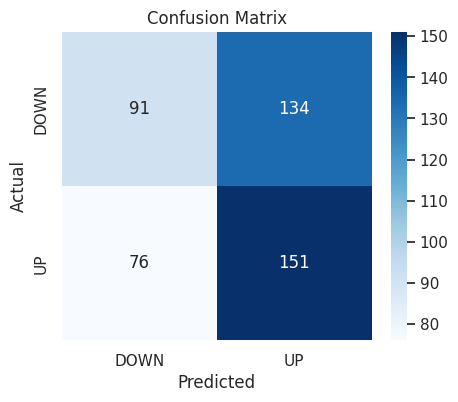

In [23]:
# Confusion matrix
plot_confusion_matrix(y_test, y_pred)


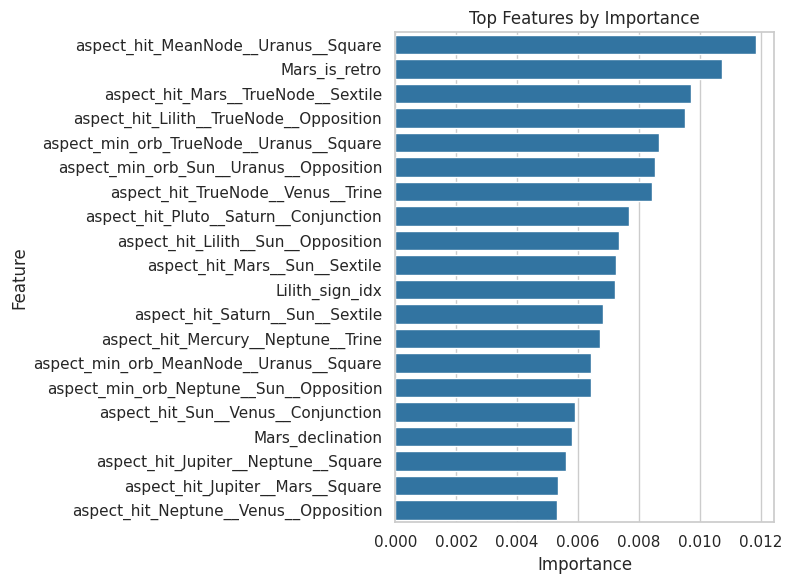

In [24]:
# Feature importance
imp_df = get_feature_importance(model, feature_cols, top_n=20)
plot_feature_importance(imp_df)


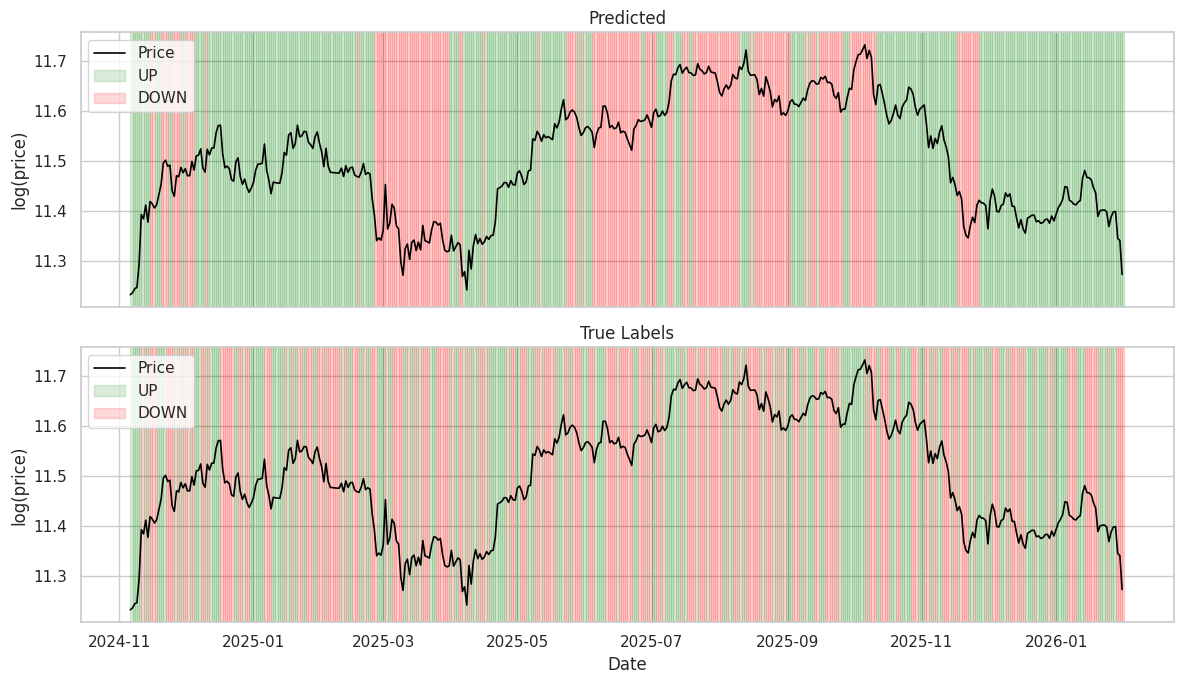

In [25]:
# Predictions on test set
# Теперь df_dataset уже содержит все дни с forward-filled метками
# Нужно только добавить close для визуализации
import pandas as pd  # На случай если запускается отдельно

test_df_plot = test_df.copy()
test_df_plot["date"] = pd.to_datetime(test_df_plot["date"])
test_df_plot = test_df_plot.merge(
    df_market[["date", "close"]].assign(date=lambda x: pd.to_datetime(x["date"])), 
    on="date", 
    how="left"
)

plot_predictions(test_df_plot, y_pred, y_true=y_test, price_mode="log")


 ## 9. (Optional) Grid Search



 Выберите один из вариантов ниже:

 - **run_grid_search** — основной поиск (coord + gauss + orb)

 - **run_full_grid_search** — полный поиск с body ablation

 - **run_body_ablation_search** — только ablation тел

In [26]:
# Настройки отображения DataFrame (чтобы видеть все колонки)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)


In [ ]:
# ══════════════════════════════════════════════════════════════════════════════════
# 🔧 НАСТРОЙКИ GRID SEARCH — ВСЕ ПАРАМЕТРЫ В ОДНОМ МЕСТЕ
# ══════════════════════════════════════════════════════════════════════════════════
#
# Просто измените значения ниже и запустите Grid Search!
# Система автоматически переберёт ВСЕ комбинации параметров.
#
# ══════════════════════════════════════════════════════════════════════════════════

from RESEARCH.grid_search import GridSearchConfig, run_grid_search

GRID_CONFIG = GridSearchConfig(
    
    # ──────────────────────────────────────────────────────────────────────────────
    # 🌍 СИСТЕМА КООРДИНАТ (откуда смотрим на планеты)
    # ──────────────────────────────────────────────────────────────────────────────
    # 
    # "geo"   = Земля в центре (классическая астрология, что видим с Земли)
    # "helio" = Солнце в центре (научная точка зрения, реальные орбиты)
    # "both"  = ОБЕ СИСТЕМЫ СРАЗУ (удваивает количество признаков!)
    #
    # Совет: начните с ["geo"], потом попробуйте ["geo", "helio", "both"]
    #        чтобы найти лучшую систему
    #
    coord_modes=["geo"],  # ← ИЗМЕНИТЕ: ["geo"], ["helio"], ["both"], или все сразу
    
    # ──────────────────────────────────────────────────────────────────────────────
    # 🔮 ОРБИСЫ АСПЕКТОВ (насколько точно планеты должны быть в аспекте)
    # ──────────────────────────────────────────────────────────────────────────────
    #
    # Орбис = допустимое отклонение от точного угла аспекта.
    # Например, соединение = 0°, но если орбис 8°, то 0°±8° считается соединением.
    #
    # 0.5 = УЗКИЕ орбисы (только очень точные аспекты, меньше шума)
    # 1.0 = СТАНДАРТНЫЕ орбисы (как в классической астрологии)
    # 1.5 = ШИРОКИЕ орбисы (больше аспектов найдётся, но и больше шума)
    #
    orb_multipliers=[0.5, 1.0, 1.7],  # ← ИЗМЕНИТЕ: можно [0.5], [1.0], [0.5, 1.0, 1.5]
    
    # ──────────────────────────────────────────────────────────────────────────────
    # 📈 ОКНО СГЛАЖИВАНИЯ ГАУССА (сколько дней "видит" алгоритм разметки)
    # ──────────────────────────────────────────────────────────────────────────────
    #
    # Это размер окна в ДНЯХ для определения "тренд UP или DOWN".
    # Чем больше окно — тем более долгосрочные тренды ловим.
    #
    #  51 = ~2.5 месяца (чувствительно к коротким движениям)
    # 101 = ~5 месяцев 
    # 151 = ~7.5 месяцев
    # 201 = ~10 месяцев (только большие тренды, игнорирует мелкие)
    #
    gauss_windows=[51,101, 151, 201],  # ← ИЗМЕНИТЕ: можно [101], [51, 101, 201]
    
    # ──────────────────────────────────────────────────────────────────────────────
    # 🔔 ШИРИНА КОЛОКОЛА ГАУССА (насколько "размыта" граница UP/DOWN)
    # ──────────────────────────────────────────────────────────────────────────────
    #
    # Это "ширина" сглаживающего колокола.
    # Чем меньше — тем резче переходы между UP и DOWN.
    # Чем больше — тем плавнее, но менее чувствительно к быстрым изменениям.
    #
    # 20.0 = УЗКИЙ колокол (резкие переходы, чувствителен к шуму)
    # 50.0 = СРЕДНИЙ колокол (баланс)
    # 80.0 = ШИРОКИЙ колокол (плавные переходы, подходит для долгосрока)
    #
    gauss_stds=[30.0, 50.0, 90.0],  # ← ИЗМЕНИТЕ: можно [50.0], [20.0, 50.0, 80.0]
    
    # ──────────────────────────────────────────────────────────────────────────────
    # 🔬 ABLATION: ИСКЛЮЧЕНИЕ АСТРО-ТЕЛ (какие планеты пробовать убирать)
    # ──────────────────────────────────────────────────────────────────────────────
    #
    # Ablation study — проверяем, какие планеты РЕАЛЬНО влияют на результат.
    # Пробуем исключать разные комбинации тел и смотрим, улучшается ли модель.
    #
    # 0 = НЕ исключать тела (только orb/gauss/coord поиск)
    # 1 = Пробовать исключать по 1 планете
    # 2 = Пробовать исключать до 2 планет
    # 4 = Пробовать исключать до 4 планет (РЕКОМЕНДУЕТСЯ)
    #
    # ⚠️ ВНИМАНИЕ: это КОМБИНАТОРНЫЙ взрыв! С 11 телами:
    #   max_exclude=1: 11 вариантов
    #   max_exclude=2: 66 вариантов
    #   max_exclude=3: 231 вариант
    #   max_exclude=4: 561 вариант
    #
    max_exclude=2,  # ← ИЗМЕНИТЕ: 0 (без ablation), 1, 2, 3, 4
    
    # ──────────────────────────────────────────────────────────────────────────────
    # 🛑 ЛИМИТ КОМБИНАЦИЙ (для тестовых запусков)
    # ──────────────────────────────────────────────────────────────────────────────
    #
    # Grid Search перебирает ВСЕ комбинации. Например:
    #   3 coord_modes × 3 orb × 3 window × 3 std = 81 комбинация!
    #   А с ablation: 81 × 561 = 45,441 комбинаций!
    #
    # Если хотите быстро проверить что всё работает — поставьте лимит.
    # None = без лимита (перебрать ВСЁ)
    #
    max_combos=None,  # ← ИЗМЕНИТЕ: None (всё) или число, например 5 для теста
    
    # ──────────────────────────────────────────────────────────────────────────────
    # 🌳 ПАРАМЕТРЫ МОДЕЛИ XGBoost (обычно менять не нужно)
    # ──────────────────────────────────────────────────────────────────────────────
    #
    # Эти параметры для обучения модели. Дефолты работают хорошо.
    # Меняйте только если понимаете что делаете.
    #
    model_params={
        "n_estimators": 500,      # Количество деревьев (больше = точнее, но дольше)
        "max_depth": 3,           # Глубина дерева (меньше = меньше переобучения)
        "learning_rate": 0.03,    # Скорость обучения (меньше = стабильнее)
        "subsample": 0.8,         # Доля данных на каждое дерево
        "colsample_bytree": 0.8,  # Доля признаков на каждое дерево
    },
)

# ══════════════════════════════════════════════════════════════════════════════════
# 🚀 ЗАПУСК GRID SEARCH
# ══════════════════════════════════════════════════════════════════════════════════
results_df = run_grid_search(df_market, GRID_CONFIG)

# Показать топ-20 лучших комбинаций
print("\n🏆 Топ-20 лучших комбинаций:")
print(results_df.head(20))


🔍 GRID SEARCH: ПЕРЕБОР ORB + GAUSSIAN + COORD_MODE

    Параметры поиска:
    • ORB множители:    [0.5, 1.0, 1.7]
    • GAUSS окна:       [51, 101, 151, 201]
    • GAUSS std:        [30.0, 50.0, 90.0]
    • COORD режимы:     ['geo']
    
🖥️ Устройство: cuda

📊 Всего комбинаций для перебора: 3312
   (включая 92 вариантов ablation: до 2 исключаемых тел)

📍 Предварительный расчёт позиций планет...

  → Режим GEO:
📍 Расчёт ГЕОЦЕНТРИЧЕСКИХ координат (Земля в центре)...


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 15422.34it/s]



🚀 НАЧИНАЕМ ПЕРЕБОР КОМБИНАЦИЙ
[1/3312] geo | O=0.5 W=51 S=30.0                             Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 771
Split: Train=2107, Val=451, Test=452
🎯 Best threshold=0.44, RECALL_MIN=0.5105, gap=0.0273
→ R_MIN=0.506 GAP=0.010 MCC=0.022
   🏆 BEST: R_MIN=0.506 GAP=0.010 (geo O=0.5 W=51 S=30.0 )
[2/3312] geo | O=0.5 W=51 S=30.0 -[Sun]                      Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 662
Split: Train=2107, Val=451, Test=452
🎯 Best threshold=0.45, RECALL_MIN=0.5142, gap=0.0089
→ R_MIN=0.470 GAP=0.100 MCC=0.041
   🏆 BEST: R_MIN=0.506 GAP=0.010 (geo O=0.5 W=51 S=30.0 )
[3/3312] geo | O=0.5 W=51 S=30.0 -[Moon]                     Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  D

In [ ]:
# EVALUATE AND VISUALIZE BEST RESULT
from RESEARCH.grid_search import evaluate_and_plot_best

best_result = evaluate_and_plot_best(df_market, results_df.iloc[0])


In [ ]:
# BODY ABLATION ONLY (uncomment to run)
# Use current params, test all body exclusion combinations

# from RESEARCH.grid_search import run_body_ablation_search
# 
# ablation_df = run_body_ablation_search(
#     df_market,
#     orb_mult=ORB_MULTIPLIER,
#     gauss_window=LABEL_CONFIG["gauss_window"],
#     gauss_std=LABEL_CONFIG["gauss_std"],
#     max_exclude=3,  # Try removing up to 3 bodies
# )


 ## 10. Save Model

In [ ]:
# Save model
from joblib import dump

artifact_dir = PROJECT_ROOT / "models_artifacts"
artifact_dir.mkdir(parents=True, exist_ok=True)

artifact = {
    "model": model.model,
    "scaler": model.scaler,
    "feature_names": feature_cols,
    "threshold": best_threshold,
    "config": {
        "label_config": LABEL_CONFIG,
        "orb_multiplier": ORB_MULTIPLIER,
        "model_params": MODEL_PARAMS,
    },
}

out_path = artifact_dir / f"xgb_astro_research.joblib"
dump(artifact, out_path)
print(f"✓ Model saved: {out_path}")


 ---

 ## Summary



 This modular pipeline makes it easy to:

 - **Debug**: Each module can be tested independently

 - **Extend**: Add new features, models, or visualizations

 - **Experiment**: Quickly try different configurations



 ### TODO:

 - [ ] Add moon phases to features

 - [ ] Grid search for astro body exclusion

 - [ ] Add houses for birth date grid search

 - [ ] Save best grid search results